### Housing analysis - zillow

In [ ]:
#import sys
#!{sys.executable} -m pip install fbprophet
#1 stnd
import pandas as pd
import numpy as np
#2 dimensional plotting
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
# multiprocessing
from multiprocessing import Pool, cpu_count
import os


In [5]:
zillow = pd.read_csv("Zip_Zhvi_SingleFamilyResidence.csv")

In [6]:

zillow.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,...,1413747.0,1405862.0,1402547.0,1390420.0,1381621.0,1375725.0,1374714.0,1381453.0,1385737.0,1389268.0
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,364892.0,...,974693.0,975616.0,975734.0,975251.0,974238.0,973104.0,971908.0,972038.0,973671.0,975642.0
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,...,1528603.0,1514894.0,1502233.0,1492429.0,1486122.0,1480426.0,1476509.0,1478980.0,1479301.0,1474994.0
3,91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,200475.0,...,335536.0,335878.0,335940.0,336092.0,336119.0,336083.0,336154.0,335860.0,336037.0,336483.0
4,84616,4,60614,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,546663.0,...,1207765.0,1208853.0,1208481.0,1206304.0,1204013.0,1201182.0,1198879.0,1198277.0,1199900.0,1200980.0


In [7]:
# select only towns in given metro areas
zillowArkansas = zillow.loc[(zillow['Metro'] == "Hot Springs") | (zillow['Metro'] == "Fayetteville-Springdale-Rogers") | 
(zillow['Metro'] == "Little Rock-North Little Rock-Conway") | (zillow['Metro'] == "Searcy")]
#remove non AR towns
zillowArkansas = zillowArkansas[zillowArkansas["State"] == "AR"]

In [8]:
# grab all columns from 1997 through 2017
zillowArkansasPlot = zillowArkansas.filter(regex="(1997|1998|1999|2000|2001|2002|2003|2004|2005|2006|2007|2008|2009|2010|2011|2012|2013|2014|2015|2016|2017|2018|2019|2020|Metro|RegionName)", axis=1)
zillowArkansasPlot = zillowArkansasPlot.groupby('Metro').mean()

In [9]:
plot = zillowArkansasPlot.transpose()

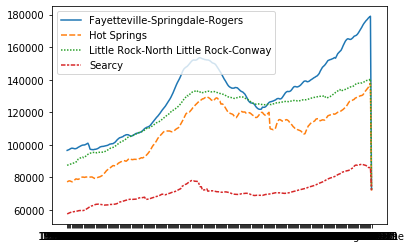

In [10]:
sns.lineplot(data=plot)
plt.show()
del plot
del zillowArkansasPlot
del zillowArkansas

In [11]:
### build housing value model

##### Analysis on missing records

In [12]:
# how many rows missing all column values?
zillowClean = zillow.filter(regex="(1997|1998|1999|2000|2001|2002|2003|2004|2005|2006|2007|2008|2009|2010|2011|2012|2013|2014|2015|2016|2017|2018|2019|2020|Metro|RegionName)", axis=1)
print(zillowClean.shape)
zillowDropAll = zillowClean.dropna(how='any',axis=0)
print(zillowDropAll.shape)
zillowDropSome = zillowClean.dropna(how='any',axis=0, thresh=252) # requiring 252 records as this is 90% of records
print("Remaining when dropped with 90% threshold ", zillowDropSome.shape)
del zillowClean
del zillow

(30464, 281)
(12652, 281)
Remaining when dropped with 90% threshold  (15754, 281)


In [13]:
# melt so we're left with just the zip (regionname) and d
zillowGrilledCheese = zillowDropSome.drop("Metro",axis=1)
zillowGrilledCheese = pd.melt(zillowGrilledCheese,id_vars=["RegionName"],var_name='ds',value_name='y')
zillowGrilledCheese.head()

,RegionName,ds,y
0,60657,1997-01-31,376806.0
1,77494,1997-01-31,201687.0
2,60614,1997-01-31,566446.0
3,77449,1997-01-31,97543.0
4,77084,1997-01-31,96895.0


In [14]:
zillowGrilledCheese.head()

,RegionName,ds,y
0,60657,1997-01-31,376806.0
1,77494,1997-01-31,201687.0
2,60614,1997-01-31,566446.0
3,77449,1997-01-31,97543.0
4,77084,1997-01-31,96895.0


#### Run forecast in batches and save as .pkl files

In [15]:
# create dataframe to store results
dataStore = zillowGrilledCheese
dataStore = dataStore.rename(columns={'ds':'output'})
dataStore = dataStore[["RegionName","output"]]
dataStore["output"] = 'empty'
dataStore = dataStore.drop_duplicates(subset='RegionName')

In [16]:
#batchOne_dataStore = dataStore[0:2999]
#batchTwo_dataStore = dataStore[3000:5999]
#batchThree_dataStore = dataStore[6000:8999]
#batchFour_dataStore = dataStore[9000:11999]
#batchFive_dataStore = dataStore[12000:15730]

In [17]:
def forecast(x):
    x = zillowGrilledCheese[zillowGrilledCheese["RegionName"] == x]
    m = Prophet(interval_width=.95)
    m.fit(x)
    future = m.make_future_dataframe(periods=36, freq='M')
    forecast = m.predict(future)
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [18]:
# pickle data for import later

In [19]:
#p = Pool(os.cpu_count())
#batchOne_dataStore["output"] = batchOne_dataStore['RegionName'].apply(forecast)
#p.close()
#p.join()
#batchOne_dataStore.to_pickle('batchOne.pkl')
#del batchOne_dataStore # remove from memory after pickled

In [20]:
#p = Pool(os.cpu_count())
#batchOne_dataStore["output"] = batchTwo_dataStore['RegionName'].apply(forecast)
#p.close()
#p.join()
#batchOne_dataStore.to_pickle('batchTwo.pkl')
#del batchTwo_dataStore # remove from memory after pickled

In [21]:
#p = Pool(os.cpu_count())
#batchThree_dataStore["output"] = batchThree_dataStore['RegionName'].apply(forecast)
#p.close()
#p.join()
#batchThree_dataStore.to_pickle('batchThree.pkl')
#del batchThree_dataStore

In [22]:
#p = Pool(os.cpu_count())
#batchFour_dataStore["output"] = batchFour_dataStore['RegionName'].apply(forecast)
#p.close()
#p.join()
#batchFour_dataStore.to_pickle('batchFour.pkl')
#del batchFour_dataStore

In [23]:
#p = Pool(os.cpu_count())
#batchFive_dataStore["output"] = batchFive_dataStore['RegionName'].apply(forecast)
#p.close()
#p.join()
#batchFive_dataStore.to_pickle('batchFive.pkl')
#del batchFive_dataStore

#### Analysis

In [24]:
#import cucumbers
results1 = pd.read_pickle("batchOne.pkl")
results2 = pd.read_pickle("batchTwo.pkl")
results3 = pd.read_pickle("batchThree.pkl")
results4 = pd.read_pickle("batchFour.pkl")
results5 = pd.read_pickle("batchFive.pkl")
results = results1.append(results2)
results = results.append(results3)
results = results.append(results4)
results = results.append(results5)

In [25]:
def extractYHAT(x):
    # provide dataframe output within overall dataframe
    x = x.tail(1)
    x = x.yhat
    return x
def extractYHAT_lower(x):
    # provide dataframe output within overall dataframe
    x = x.tail(1)
    x = x.yhat_lower
    return x
def extractYHAT_upper(x):
    # provide dataframe output within overall dataframe
    x = x.tail(1)
    x = x.yhat_upper
    return x

In [26]:
results["yhat"] = results["output"].apply(extractYHAT)
results["yhat_lower"] = results["output"].apply(extractYHAT_lower)
results["yhat_upper"] = results["output"].apply(extractYHAT_upper)


In [27]:
resultsDF = results[["RegionName","yhat_lower","yhat_upper","yhat"]]

In [28]:
# get actuals from end of april/march
actuals = zillowDropSome[["RegionName","2020-03-31"]]

In [29]:
resultsDF = resultsDF.merge(actuals,left_on='RegionName',right_on='RegionName')

In [30]:
# biggest growth
resultsDF["growth"] = (resultsDF["yhat"] - resultsDF["2020-03-31"]) 
resultsDF["growth"] = resultsDF["growth"].round(0)
resultsDF = resultsDF.sort_values(by=['growth'], ascending=False)

In [31]:
resultsDF.head()

,RegionName,yhat_lower,yhat_upper,yhat,2020-03-31,growth
4445,90210,6.857030e+06,7.843244e+06,7.390265e+06,5902641.0,1487624.0
9201,94027,7.444196e+06,8.607867e+06,8.043161e+06,6661460.0,1381701.0
963,90020,4.890803e+06,5.664139e+06,5.277723e+06,4013833.0,1263890.0
6721,90402,5.119926e+06,6.049860e+06,5.623861e+06,4449241.0,1174620.0
5262,94301,5.111849e+06,5.758155e+06,5.407826e+06,4243887.0,1163939.0


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


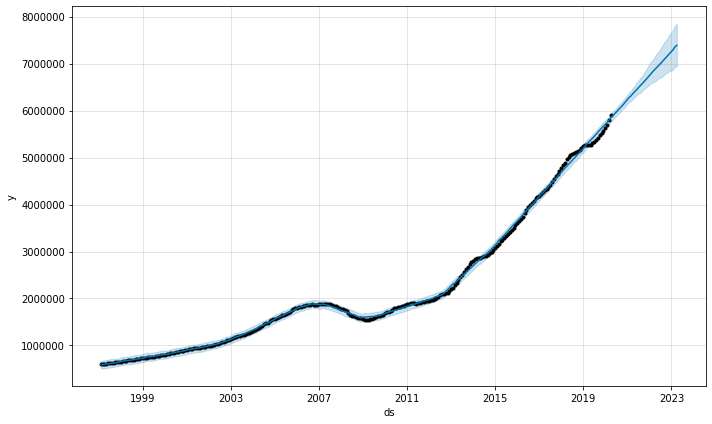

In [32]:
# visualize winners
    x = zillowGrilledCheese[zillowGrilledCheese["RegionName"] == 90210]
    m = Prophet(interval_width=.95)
    m.fit(x)
    future = m.make_future_dataframe(periods=36, freq='M')
    forecast = m.predict(future)
    m.plot(forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


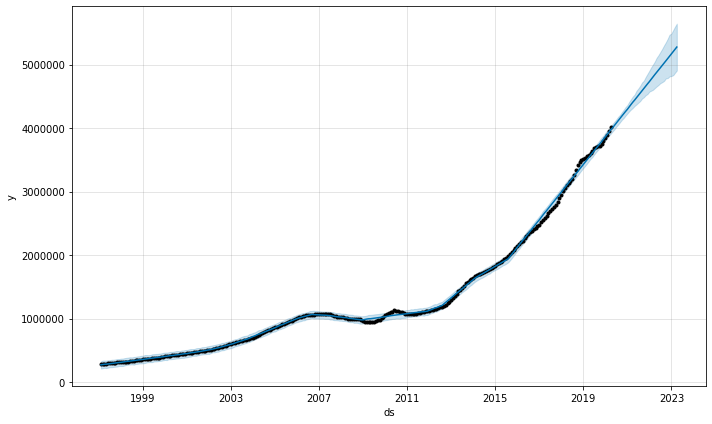

In [33]:
# visualize winners
    x = zillowGrilledCheese[zillowGrilledCheese["RegionName"] == 90020]
    m = Prophet(interval_width=.95)
    m.fit(x)
    future = m.make_future_dataframe(periods=36, freq='M')
    forecast = m.predict(future)
    m.plot(forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


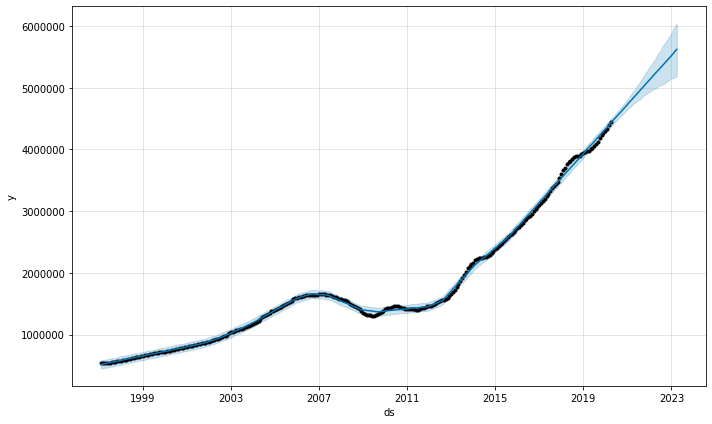

In [34]:
# visualize winners
    x = zillowGrilledCheese[zillowGrilledCheese["RegionName"] == 90402]
    m = Prophet(interval_width=.95)
    m.fit(x)
    future = m.make_future_dataframe(periods=36, freq='M')
    forecast = m.predict(future)
    m.plot(forecast)